# Clustering on Open Food Facts dataset

### Load data

In [1]:
# Imports libraries
from scripts import analyse_columns, clean
from scripts.kmeans import kmeans_clustering, plot_elbow_method
from scripts.plots import plot_clusters_2d, plot_cluster_sizes
from scripts.model_utils import load_model

import pandas as pd
import numpy as np
# import mlflow
from sklearn.preprocessing import StandardScaler

# mlflow.autolog()

2025/03/27 14:31:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [2]:
# Load Open Food Facts dataset csv
path = "data/en.openfoodfacts.org.products.csv"

df = pd.read_csv(path, 
                 sep='\\t', 
                 encoding="utf-8",
                 on_bad_lines='skip',
                 nrows=300000)

C:\Users\jaech\AppData\Local\Temp\ipykernel_16748\4190858480.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path,


In [3]:
# Display basic information about the dataset
print("\nFirst few rows:")
display(df.head())


First few rows:


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,last_modified_by,last_updated_t,last_updated_datetime,...,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g,sulphate_100g,nitrate_100g,acidity_100g
0,54,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1582569031,2020-02-24T18:30:31Z,1733085204,2024-12-01T20:33:24Z,NaN,1.740205e+09,2025-02-22T06:23:42Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,63,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1673620307,2023-01-13T14:31:47Z,1739902555,2025-02-18T18:15:55Z,waistline-app,1.740360e+09,2025-02-24T01:26:17Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,114,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1580066482,2020-01-26T19:21:22Z,1737247862,2025-01-19T00:51:02Z,smoothie-app,1.740075e+09,2025-02-20T18:10:18Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,http://world-en.openfoodfacts.org/product/0000...,inf,1634745456,2021-10-20T15:57:36Z,1742247341,2025-03-17T21:35:41Z,roboto-app,1.742247e+09,2025-03-17T21:35:41Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,105,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1572117743,2019-10-26T19:22:23Z,1738073570,2025-01-28T14:12:50Z,NaN,1.740085e+09,2025-02-20T20:57:12Z,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Display number of rows and columns
print(df.shape)

(300000, 206)


In [5]:
# Show summary statistics of numeric columns
# Display detailed summary statistics of numeric columns
print("\nSummary statistics of numeric columns:")
print(df.describe(include=[np.number], percentiles=[.05, .25, .5, .75, .95]))

# Show additional statistics
print("\nSkewness of numeric columns:")
print(df.select_dtypes(include=[np.number]).skew())

print("\nKurtosis of numeric columns:")
print(df.select_dtypes(include=[np.number]).kurtosis())

# Count number of non-null values for each numeric column
print("\nNumber of non-null values in numeric columns:")
print(df.select_dtypes(include=[np.number]).count())


Summary statistics of numeric columns:
               code     created_t  last_modified_t  last_updated_t  cities  \
count  3.000000e+05  3.000000e+05     3.000000e+05    2.999990e+05     0.0   
mean   3.142524e+10  1.602130e+09     1.675095e+09    1.729909e+09     NaN   
std    1.793752e+10  7.930433e+07     6.009212e+07    1.253325e+07     NaN   
min    1.000000e+00  1.332445e+09     1.424628e+09    1.701775e+09     NaN   
5%     3.759174e+05  1.489060e+09     1.587584e+09    1.707823e+09     NaN   
25%    1.590006e+10  1.537557e+09     1.627272e+09    1.720271e+09     NaN   
50%    3.594086e+10  1.592158e+09     1.685832e+09    1.734786e+09     NaN   
75%    4.222285e+10  1.660253e+09     1.728054e+09    1.738830e+09     NaN   
95%    5.974995e+10  1.726604e+09     1.740367e+09    1.740367e+09     NaN   
max    6.263938e+10  1.742962e+09     1.742967e+09    1.742967e+09     NaN   

       allergens_en  serving_quantity    additives_n  additives  \
count           0.0      1.738320e

### Data Processing

In [6]:
# Keep only relevant columns (nutritional columns)

# All other columns are irrelevant
irrelevant_columns = [col for col in df.columns if not col.endswith('_100g')]

# Clean dataset using the clean() function
df_cleaned = clean.clean(df, irrelevant_columns=irrelevant_columns, missing_threshold=0.5)

# Display cleaned dataset info
print("\nCleaned dataset shape:", df.shape)
print("\nRemaining columns:")
print(df_cleaned.columns.tolist())



Cleaned dataset shape: (300000, 206)

Remaining columns:
['energy-kcal_100g', 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'fruits-vegetables-nuts-estimate-from-ingredients_100g']


In [7]:
display(df_cleaned.head())

,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,332.0,1389.0,25.0,17.3,3.0,1.0,NaN,23.0,1.200,0.48,0.000000
2,NaN,2415.0,44.0,28.0,30.0,27.0,NaN,7.1,0.025,0.01,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011335


In [8]:
# Handle missing values by filling with median for numeric columns
# Using median instead of mean to be more robust to outliers
df_cleaned = df_cleaned.fillna(df_cleaned.median())

# Verify no more NaN values exist
print("\nNumber of NaN values remaining:")
print(df_cleaned.isna().sum().sum())

# Display first few rows to verify changes
print("\nFirst few rows after handling missing values:")
display(df_cleaned.head())

print("\nShape")
print(df_cleaned.shape)



Number of NaN values remaining:
0

First few rows after handling missing values:


,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,270.0,1130.0,5.172414,1.5,22.988503,5.26,1.41,5.0,0.4325,0.173,0.670000
1,332.0,1389.0,25.000000,17.3,3.000000,1.00,1.41,23.0,1.2000,0.480,0.000000
2,270.0,2415.0,44.000000,28.0,30.000000,27.00,1.41,7.1,0.0250,0.010,0.670000
3,270.0,1130.0,5.172414,1.5,22.988503,5.26,1.41,5.0,0.4325,0.173,100.000000
4,270.0,1130.0,5.172414,1.5,22.988503,5.26,1.41,5.0,0.4325,0.173,0.011335



Shape
(300000, 11)


In [9]:
# Scale features using StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_cleaned),
    columns=df_cleaned.columns
)

# Display first few rows of scaled data
print("First few rows of scaled data:")
display(df_scaled.head())

# Verify scaling - mean should be ~0 and std should be ~1
print("\nMean of scaled features:")
print(df_scaled.mean().round(2))
print("\nStandard deviation of scaled features:")
print(df_scaled.std().round(2))



First few rows of scaled data:


,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,-0.133253,-0.132839,-0.234255,-0.128697,-0.241410,-0.276793,-0.061425,-0.167371,-0.001826,-0.001826,-0.397221
1,-0.014850,-0.014526,0.226550,0.447083,-0.540333,-0.378692,-0.061425,0.624400,-0.001826,-0.001826,-0.425070
2,-0.133253,0.454158,0.668122,0.837010,-0.136555,0.243229,-0.061425,-0.074998,-0.001826,-0.001826,-0.397221
3,-0.133253,-0.132839,-0.234255,-0.128697,-0.241410,-0.276793,-0.061425,-0.167371,-0.001826,-0.001826,3.731573
4,-0.133253,-0.132839,-0.234255,-0.128697,-0.241410,-0.276793,-0.061425,-0.167371,-0.001826,-0.001826,-0.424599



Mean of scaled features:
energy-kcal_100g                                         0.0
energy_100g                                              0.0
fat_100g                                                 0.0
saturated-fat_100g                                       0.0
carbohydrates_100g                                      -0.0
sugars_100g                                              0.0
fiber_100g                                               0.0
proteins_100g                                            0.0
salt_100g                                               -0.0
sodium_100g                                              0.0
fruits-vegetables-nuts-estimate-from-ingredients_100g   -0.0
dtype: float64

Standard deviation of scaled features:
energy-kcal_100g                                         1.0
energy_100g                                              1.0
fat_100g                                                 1.0
saturated-fat_100g                                       1.0
carb

In [10]:
# Remove outliers using IQR method
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = Q1 - 1.5 * IQR 
    upper_bound = Q3 + 1.5 * IQR
    
    # Create mask for values within bounds
    mask = ~((df < lower_bound) | (df > upper_bound)).any(axis=1)
    
    return df[mask]

# Remove outliers and store in new DataFrame
print("Shape before removing outliers:", df_scaled.shape)
df_scaled_no_outliers = remove_outliers(df_scaled)
print("Shape after removing outliers:", df_scaled_no_outliers.shape)
print(f"Removed {df_scaled.shape[0] - df_scaled_no_outliers.shape[0]} outliers")

# Update original data without outliers for consistency
df_cleaned = df_cleaned.loc[df_scaled_no_outliers.index]


Shape before removing outliers: (300000, 11)
Shape after removing outliers: (144826, 11)
Removed 155174 outliers


In [11]:
# Create cleaned dataset


### Feature Engineering

In [12]:
# Create new features


In [13]:
# Do PCA to visualize high-dimensional data


In [14]:
# Analyze feature importance and correlations


### Clustering Analysis

- #### K-Means

2025/03/27 14:32:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '77ec4a05325f4cd2ae5fad6c675b50d6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/03/27 14:32:08 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/03/27 14:32:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a3b00bcec5624d52bf636cd1fd301e02', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/03/27 14:32:23 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2025/03/27

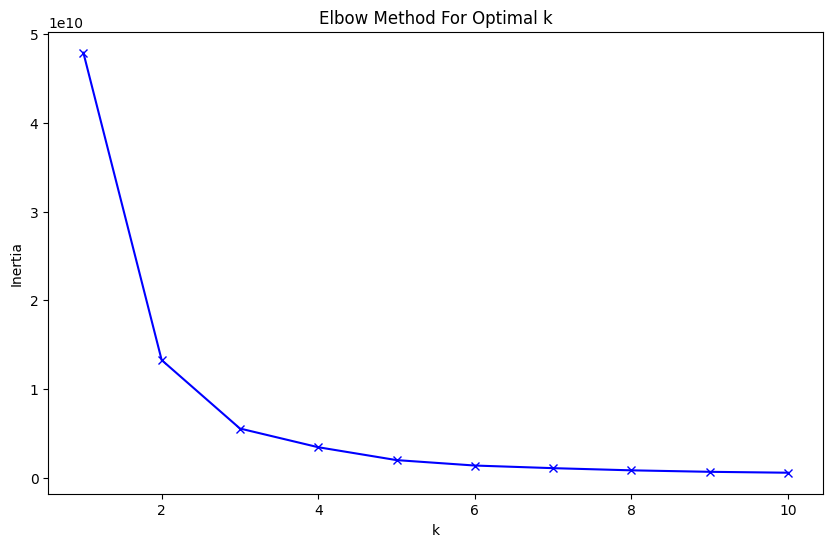

In [15]:
# Determine optimal number of clusters
plot_elbow_method(df_cleaned.values)

In [16]:
# Perform clustering
kmeans, labels, metrics = kmeans_clustering(df_cleaned.values)


2025/03/27 14:34:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c6fc5d839aae45deb4247f2683c9d565', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/03/27 14:34:12 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.


Model saved to: models\kmeans_food_clusters_20250327_143421.joblib


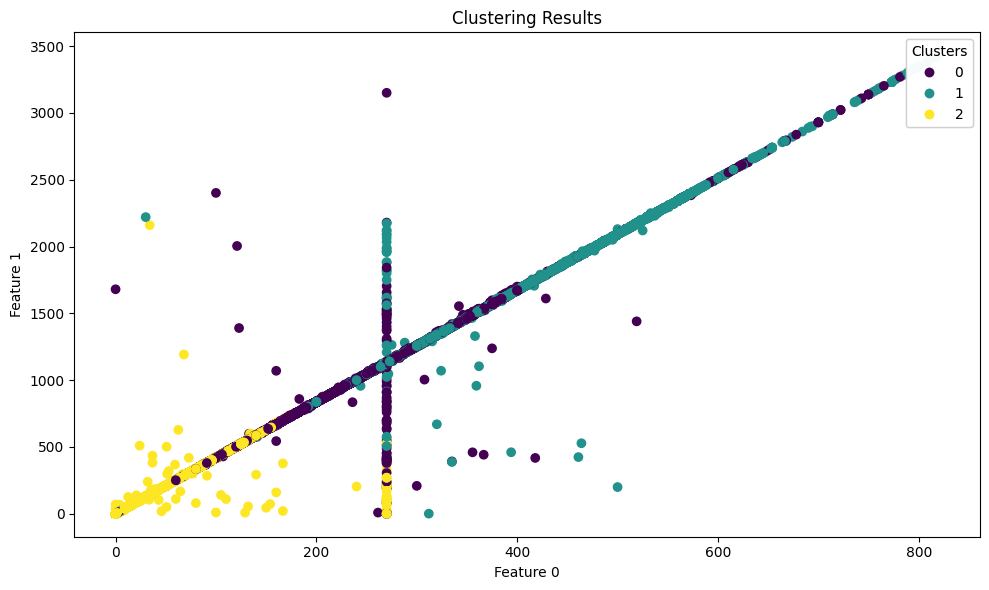

In [17]:
# Visualize the results
plot_clusters_2d(df_cleaned.values, labels, x_idx=0, y_idx=1)

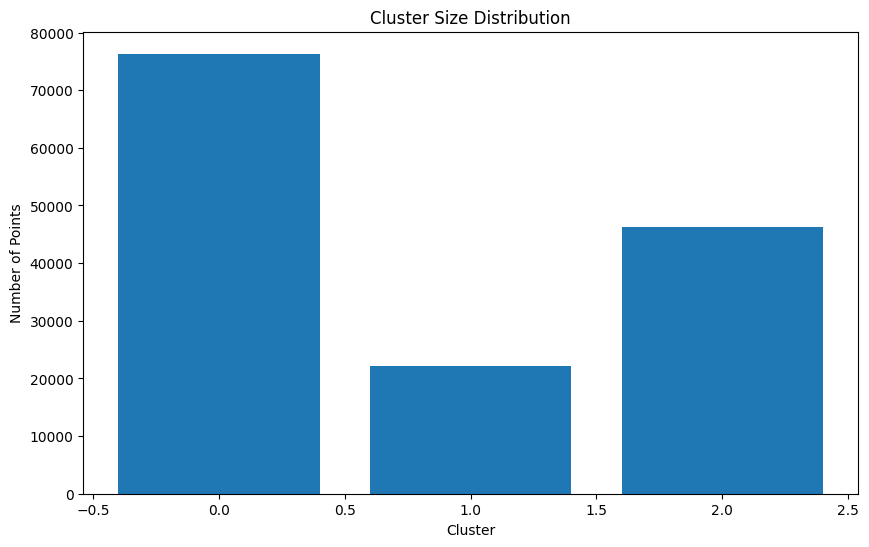

In [18]:
# Show cluster size distribution
plot_cluster_sizes(labels)

In [19]:
# DBSCAN clustering

In [20]:
# Gaussian Mixture Model (GMM) clustering


In [21]:
# Hierarchical clustering


### Cluster evaluation and comparison

In [22]:
# Compare clustering results using metrics (Silhouette score, Calinski-Harabasz index, Davies-Bouldin index)

In [23]:
# Visualize cluster comparisons (word clouds, ...)

In [24]:
# Analyse cluster characteristics and interpret results

### Visualization and Insights

In [25]:
# Various visualizations (cluster distribution plots, feature importance within clusters, pairplots with key features, heatmaps of cluster characteristics)


In [26]:
# Generate insights about food product groupings

In [27]:
# Indentify patterns and trends in the clusters

### Conclusions and recommendations

In [28]:
# Summarize findings


In [29]:
# Compare strengths and weaknesses of different clustering methods


In [30]:
# Provide recommendations for practical applications


In [31]:
#Suggest potential areas for futher analysis